In [1]:
import scanpy as sc
import squidpy as sq
import os
import pandas as pd
import numpy as np

from calculate_adj import *
from util import *
from SpaGCN import *
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder 
from sklearn.cluster import KMeans

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 读取DLPFC数据

/home/ubuntu/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


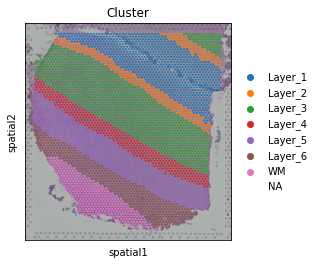

In [2]:
section_list = ['151507', '151508', '151509', '151510', '151669', '151670', '151671', '151672', '151673', '151674', '151675', '151676']
section_id = section_list[0]

adata = sc.read_visium(path=os.path.join('..', 'dataset', 'DLPFC', section_id))
adata.var_names_make_unique()

Ann_df = pd.read_csv(os.path.join('..', 'dataset', 'DLPFC', section_id, 'ground_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Cluster'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
sc.pl.spatial(adata, color='Cluster')

## 生成邻接矩阵(这里只计算距离)

In [3]:
pos = adata.obsm['spatial'].T
x_array = pos[0]
y_array = pos[1]

adj = calculate_adj_matrix(pos[0], pos[1], histology=False)

Calculateing adj matrix using xy only...


## 对features进行初始化

In [4]:
prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

## 计算用于归一化邻接矩阵的超参数l

In [5]:
p=0.5 
l=search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 312.00739089512916]
Run 2: l [0.01, 500.005], p [0.0, 85.49689483642578]
Run 3: l [0.01, 250.0075], p [0.0, 21.679431915283203]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.808452129364014]
Run 5: l [0.01, 62.509375], p [0.0, 0.5168116092681885]
Run 6: l [31.2596875, 62.509375], p [0.0003445148468017578, 0.5168116092681885]
Run 7: l [46.884531249999995, 62.509375], p [0.07710742950439453, 0.5168116092681885]
Run 8: l [54.69695312499999, 62.509375], p [0.24361300468444824, 0.5168116092681885]
Run 9: l [58.6031640625, 62.509375], p [0.3679589033126831, 0.5168116092681885]
Run 10: l [60.556269531249995, 62.509375], p [0.43952035903930664, 0.5168116092681885]
Run 11: l [61.532822265625, 62.509375], p [0.47747576236724854, 0.5168116092681885]
recommended l =  62.021098632812496


## 确定louvain算法需要的分辨率

In [6]:
n_clusters=8
r_seed=t_seed=n_seed=100
#Seaech for suitable resolution
res=search_res(adata, adj, l, n_clusters, start=0.9, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.9 step =  0.1
Initializing cluster centers with louvain, resolution =  0.9


100%|██████████| 20/20 [00:02<00:00,  7.49it/s]

Res =  0.9 Num of clusters =  8
recommended res =  0.9


## GCN

In [7]:
clf=SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=100)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')
#Do cluster refinement(optional)
#shape="hexagon" for Visium data, "square" for ST data.
adj_2d=calculate_adj_matrix(x=x_array,y=y_array, histology=False)
refined_pred=refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adj_2d, shape="hexagon")
adata.obs["refined_pred"]=refined_pred
adata.obs["refined_pred"]=adata.obs["refined_pred"].astype('category')

Initializing cluster centers with louvain, resolution =  0.9


100%|██████████| 100/100 [00:12<00:00,  7.89it/s]


Calculateing adj matrix using xy only...


## 可视化、ARI

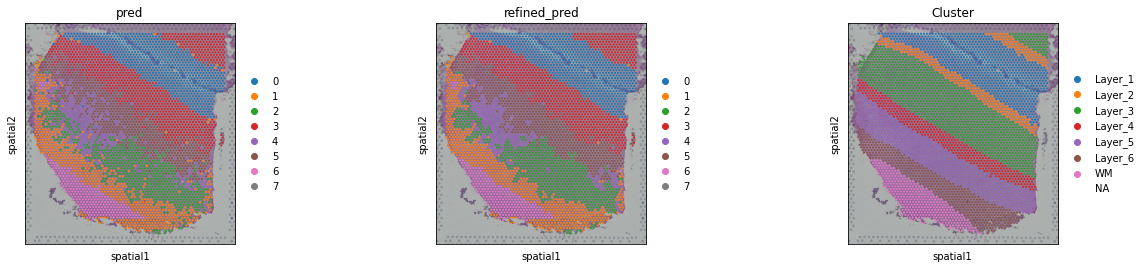

pred: 0.4764292986208793
refined_pred: 0.5074035787895159
fscore_pred: 0.2659725508755324
fscore_refined_pred 0.2650260293421675


In [8]:
sc.pl.spatial(adata, color=['pred', "refined_pred", 'Cluster'])
label = LabelEncoder().fit_transform(adata.obs['Cluster'])
pred = LabelEncoder().fit_transform(adata.obs['pred'])
refined_pred = LabelEncoder().fit_transform(adata.obs['refined_pred'])
print('pred:', metrics.adjusted_rand_score(label, pred))
print('refined_pred:', metrics.adjusted_rand_score(label, refined_pred))
_, _, fscore_pred, _ = metrics.precision_recall_fscore_support(label, pred, average='micro')
_, _, fscore_refined_pred, _ = metrics.precision_recall_fscore_support(label, refined_pred, average='micro')
print('fscore_pred:', fscore_pred)
print('fscore_refined_pred', fscore_refined_pred)

## MERFISH数据集

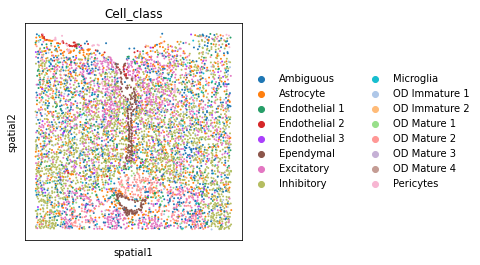

In [9]:
adata = sq.datasets.merfish(path=os.path.join('..', 'dataset', 'merfish3d.h5ad'))
adata = adata[adata.obs['Bregma'] == 1.0]
sc.pl.spatial(adata, color='Cell_class', spot_size=1e-2)

In [11]:
pos = adata.obsm['spatial'].T
x_array = [pos[0][i] * 10000 for i in range(len(pos[0]))]
y_array = [pos[1][i] * 10000 for i in range(len(pos[1]))]

adj = calculate_adj_matrix(x_array, y_array, histology=False)

prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

p=0.5 
l=search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

n_clusters=16
r_seed=t_seed=n_seed=100
#Seaech for suitable resolution
res=search_res(adata, adj, l, n_clusters, start=0.9, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

clf=SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=1500)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')
#Do cluster refinement(optional)
#shape="hexagon" for Visium data, "square" for ST data.
adj_2d=calculate_adj_matrix(x=x_array,y=y_array, histology=False)
refined_pred=refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adj_2d, shape="hexagon")
adata.obs["refined_pred"]=refined_pred
adata.obs["refined_pred"]=adata.obs["refined_pred"].astype('category')

Calculateing adj matrix using xy only...
Run 1: l [0.01, 1000], p [0.0, 350.6201030852927]
Run 2: l [0.01, 500.005], p [0.0, 95.01722717285156]
Run 3: l [0.01, 250.0075], p [0.0, 24.629474639892578]
Run 4: l [0.01, 125.00874999999999], p [0.0, 6.059864521026611]
Run 5: l [0.01, 62.509375], p [0.0, 1.293855905532837]
Run 6: l [31.2596875, 62.509375], p [0.20327258110046387, 1.293855905532837]
Run 7: l [31.2596875, 46.884531249999995], p [0.20327258110046387, 0.6319359540939331]
Run 8: l [39.072109375, 46.884531249999995], p [0.3885303735733032, 0.6319359540939331]
recommended l =  42.978320312499996
Start at res =  0.9 step =  0.1
Initializing cluster centers with louvain, resolution =  0.9


100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


Res =  0.9 Num of clusters =  13
Initializing cluster centers with louvain, resolution =  1.0


100%|██████████| 20/20 [00:05<00:00,  3.84it/s]


Res =  1.0 Num of clusters =  14
Res changed to 1.0
Initializing cluster centers with louvain, resolution =  1.1


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Res =  1.1 Num of clusters =  15
Res changed to 1.1
Initializing cluster centers with louvain, resolution =  1.2000000000000002


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


Res =  1.2000000000000002 Num of clusters =  16
recommended res =  1.2000000000000002
Initializing cluster centers with louvain, resolution =  1.2000000000000002


100%|██████████| 1500/1500 [06:50<00:00,  3.65it/s]


Calculateing adj matrix using xy only...


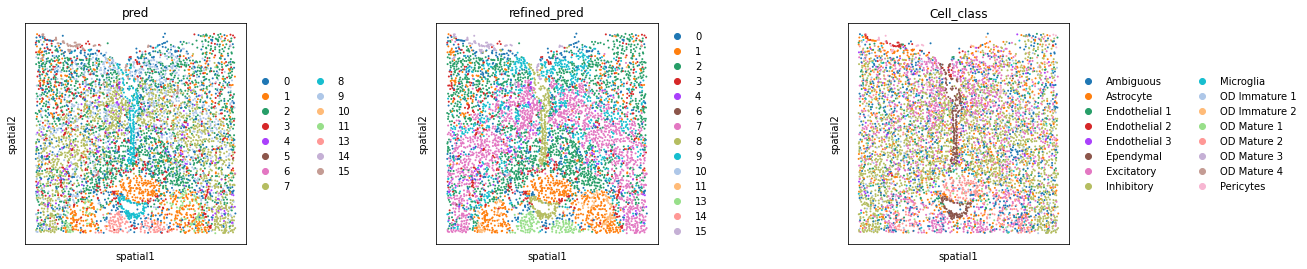

pred: 0.32938701653618396
refined_pred: 0.2538762016618499


In [12]:
sc.pl.spatial(adata, color=['pred', "refined_pred", 'Cell_class'], spot_size=1e-2)
label = LabelEncoder().fit_transform(adata.obs['Cell_class'])
pred = LabelEncoder().fit_transform(adata.obs['pred'])
refined_pred = LabelEncoder().fit_transform(adata.obs['refined_pred'])
print('pred:', metrics.adjusted_rand_score(label, pred))
print('refined_pred:', metrics.adjusted_rand_score(label, refined_pred))